In [1]:
"""
Pure CTGAN Implementation - Direct use of CTGAN without SDV wrapper.
Provides maximum control and performance for synthetic data generation.
"""

'\nPure CTGAN Implementation - Direct use of CTGAN without SDV wrapper.\nProvides maximum control and performance for synthetic data generation.\n'

<a id = 'Index:'></a>

# Table of Contents


- [Part 1.1 - Synthetic Data Generation - Classes Define](#pa11ne)
- [Part 1.2 - Synthetic Data Generation - Execution](#p12ion)
- [Part 3 - Data Exploratory Analysis](#3ysis)
- [End](#end)

In [2]:
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import warnings

from contextlib import contextmanager
from dataclasses import dataclass, field
from datetime import datetime
from pathlib import Path
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from typing import Union, List, Optional, Dict, Any, Tuple

# Try to import the original CTGAN - fallback to our implementation if not available
try:
    from ctgan import CTGAN
    CTGAN_AVAILABLE = True
except ImportError:
    CTGAN_AVAILABLE = False
    print("⚠️ Original CTGAN not found. Using built-in implementation.")

warnings.filterwarnings("ignore", category=UserWarning)

[Back to top](#Index:)

<a id='part11'></a>

## Part 1.1 - Synthetic Data Generation - Classes Define

In [3]:
@dataclass
class PureCTGANConfig:
    """Configuration for pure CTGAN implementation."""
    
    # File paths
    seed_file: str = "final_agile_seed.csv"
    data_folder: Path = field(default_factory=lambda: Path("../data"))
    config_folder: Path = field(default_factory=lambda: Path("../config"))
    
    # CTGAN Architecture
    embedding_dim: int = 128
    generator_dim: Tuple[int, ...] = (256, 256)
    discriminator_dim: Tuple[int, ...] = (256, 256)
    
    # Training parameters
    epochs: int = 300
    batch_size: int = 500
    generator_lr: float = 2e-4
    discriminator_lr: float = 2e-4
    beta1: float = 0.5
    beta2: float = 0.999
    l2_penalty: float = 1e-6
    
    # CTGAN specific
    pac: int = 10  # Packing parameter
    lambda_gp: float = 10.0  # Gradient penalty coefficient
    
    # Data processing
    categorical_columns: List[str] = field(default_factory=list)
    discrete_columns: List[str] = field(default_factory=list)
    
    # Generation
    num_samples: int = 10000
    
    # Hardware
    device: str = "auto"  # "auto", "cpu", "cuda"
    
    # Output
    output_filename: str = "synthetic_ISBSG2016R1_1_agile_ctgan_generated.csv"
    model_filename: str = "pure_ctgan_model.pkl"
    
    def __post_init__(self):
        """Initialize paths and device."""
        self.data_folder = Path(self.data_folder)
        self.config_folder = Path(self.config_folder)
        self._ensure_directories()
        
        if self.device == "auto":
            self.device = "cuda" if torch.cuda.is_available() else "cpu"
    
    def _ensure_directories(self):
        """Create necessary directories."""
        self.data_folder.mkdir(parents=True, exist_ok=True)
        self.config_folder.mkdir(parents=True, exist_ok=True)


class DataTransformer:
    """Advanced data transformer for CTGAN preprocessing."""
    
    def __init__(self, categorical_columns: List[str] = None, 
                 discrete_columns: List[str] = None):
        self.categorical_columns = categorical_columns or []
        self.discrete_columns = discrete_columns or []
        self.label_encoders = {}
        self.scalers = {}
        self.column_info = {}
        self.fitted = False
    
    def fit(self, data: pd.DataFrame):
        """Fit transformers to the data."""
        self.column_info = {}
        
        for column in data.columns:
            info = {'name': column}
            
            if column in self.categorical_columns or data[column].dtype == 'object':
                # Categorical column
                info['type'] = 'categorical'
                le = LabelEncoder()
                # Handle missing values
                values = data[column].fillna('__MISSING__')
                le.fit(values)
                self.label_encoders[column] = le
                info['num_categories'] = len(le.classes_)
                info['categories'] = le.classes_.tolist()
                
            elif column in self.discrete_columns:
                # Discrete numerical column
                info['type'] = 'discrete'
                info['min'] = data[column].min()
                info['max'] = data[column].max()
                
            else:
                # Continuous numerical column
                info['type'] = 'continuous'
                scaler = StandardScaler()
                scaler.fit(data[[column]])
                self.scalers[column] = scaler
                info['mean'] = float(data[column].mean())
                info['std'] = float(data[column].std())
            
            self.column_info[column] = info
        
        self.fitted = True
        return self
    
    def transform(self, data: pd.DataFrame) -> np.ndarray:
        """Transform data for CTGAN training."""
        if not self.fitted:
            raise ValueError("Transformer must be fitted before transform")
        
        transformed_data = []
        
        for column in data.columns:
            info = self.column_info[column]
            
            if info['type'] == 'categorical':
                # Transform categorical
                values = data[column].fillna('__MISSING__')
                encoded = self.label_encoders[column].transform(values)
                # One-hot encode
                one_hot = np.eye(info['num_categories'])[encoded]
                transformed_data.append(one_hot)
                
            elif info['type'] == 'discrete':
                # Normalize discrete values
                values = data[column].values.reshape(-1, 1)
                normalized = (values - info['min']) / (info['max'] - info['min'] + 1e-8)
                transformed_data.append(normalized)
                
            else:
                # Scale continuous values
                scaled = self.scalers[column].transform(data[[column]])
                transformed_data.append(scaled)
        
        return np.concatenate(transformed_data, axis=1)
    
    def inverse_transform(self, data: np.ndarray) -> pd.DataFrame:
        """Convert transformed data back to original format."""
        if not self.fitted:
            raise ValueError("Transformer must be fitted before inverse_transform")
        
        result_data = {}
        start_idx = 0
        
        for column in self.column_info.keys():
            info = self.column_info[column]
            
            if info['type'] == 'categorical':
                # Inverse categorical transformation
                end_idx = start_idx + info['num_categories']
                one_hot_data = data[:, start_idx:end_idx]
                categories = np.argmax(one_hot_data, axis=1)
                decoded = self.label_encoders[column].inverse_transform(categories)
                # Handle missing values
                decoded = np.where(decoded == '__MISSING__', np.nan, decoded)
                result_data[column] = decoded
                start_idx = end_idx
                
            elif info['type'] == 'discrete':
                # Inverse discrete transformation
                end_idx = start_idx + 1
                normalized_data = data[:, start_idx:end_idx].flatten()
                original = normalized_data * (info['max'] - info['min']) + info['min']
                result_data[column] = np.round(original).astype(int)
                start_idx = end_idx
                
            else:
                # Inverse continuous transformation
                end_idx = start_idx + 1
                scaled_data = data[:, start_idx:end_idx]
                original = self.scalers[column].inverse_transform(scaled_data).flatten()
                result_data[column] = original
                start_idx = end_idx
        
        return pd.DataFrame(result_data)
    
    def get_output_dimensions(self) -> int:
        """Get the total number of dimensions after transformation."""
        total_dim = 0
        for info in self.column_info.values():
            if info['type'] == 'categorical':
                total_dim += info['num_categories']
            else:
                total_dim += 1
        return total_dim

    def auto_detect_columns(self, data: pd.DataFrame, 
                           categorical_threshold: int = 10) -> Dict[str, List[str]]:
        """Auto-detect column types based on heuristics."""
        categorical = []
        discrete = []
        
        for col in data.columns:
            if data[col].dtype == 'object':
                categorical.append(col)
            elif data[col].dtype in ['int64', 'int32']:
                unique_vals = data[col].nunique()
                if unique_vals <= categorical_threshold:
                    categorical.append(col)  # Few unique integers = categorical
                else:
                    discrete.append(col)
        
        return {'categorical': categorical, 'discrete': discrete}
    


class Generator(nn.Module):
    """CTGAN Generator network."""
    
    def __init__(self, input_dim: int, output_dim: int, generator_dim: Tuple[int, ...]):
        super(Generator, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        for dim in generator_dim:
            layers.extend([
                nn.Linear(prev_dim, dim),
                nn.BatchNorm1d(dim),
                nn.ReLU()
            ])
            prev_dim = dim
        
        layers.append(nn.Linear(prev_dim, output_dim))
        layers.append(nn.Tanh())
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)


class Discriminator(nn.Module):
    """CTGAN Discriminator network."""
    
    def __init__(self, input_dim: int, discriminator_dim: Tuple[int, ...], pac: int = 1):
        super(Discriminator, self).__init__()
        self.pac = pac
        
        layers = []
        prev_dim = input_dim * pac
        
        for dim in discriminator_dim:
            layers.extend([
                nn.Linear(prev_dim, dim),
                nn.LeakyReLU(0.2),
                nn.Dropout(0.5)
            ])
            prev_dim = dim
        
        layers.append(nn.Linear(prev_dim, 1))
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        batch_size = x.size(0)
        
        if self.pac > 1:
            # Reshape for packing
            x = x.view(-1, self.pac, x.size(-1))
            x = x.view(-1, x.size(-1) * self.pac)
        
        return self.model(x)


class PureCTGAN:
    """Pure CTGAN implementation without SDV dependencies."""
    
    def __init__(self, config: PureCTGANConfig):
        self.config = config
        self.logger = self._setup_logging()
        self.device = torch.device(config.device)
        
        # Components
        self.transformer = None
        self.generator = None
        self.discriminator = None
        self.gen_optimizer = None
        self.disc_optimizer = None
        
        # Training state
        self.trained = False
        self.training_history = []
        
        self.logger.info(f"Initialized Pure CTGAN on {self.device}")
    
    def _setup_logging(self) -> logging.Logger:
        """Setup logging configuration."""
        logger = logging.getLogger(f"{__name__}.PureCTGAN")
        logger.setLevel(logging.INFO)
        
        if not logger.handlers:
            handler = logging.StreamHandler()
            formatter = logging.Formatter(
                '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
            )
            handler.setFormatter(formatter)
            logger.addHandler(handler)
        
        return logger
    
    @contextmanager
    def _timer(self, operation: str):
        """Context manager for timing operations."""
        import time
        start = time.time()
        self.logger.info(f"Starting {operation}...")
        try:
            yield
            elapsed = time.time() - start
            self.logger.info(f"✓ {operation} completed in {elapsed:.2f}s")
        except Exception as e:
            elapsed = time.time() - start
            self.logger.error(f"✗ {operation} failed after {elapsed:.2f}s: {e}")
            raise
    
    def fit(self, data: pd.DataFrame):
        """Train the CTGAN model on the provided data."""
        with self._timer("CTGAN Training"):
            # Prepare data
            self.transformer = DataTransformer(
                categorical_columns=self.config.categorical_columns,
                discrete_columns=self.config.discrete_columns
            )
            self.transformer.fit(data)
            
            # Transform data
            transformed_data = self.transformer.transform(data)
            data_dim = transformed_data.shape[1]
            
            self.logger.info(f"Data shape: {data.shape} -> {transformed_data.shape}")
            
            # Initialize networks
            noise_dim = self.config.embedding_dim
            self.generator = Generator(
                noise_dim, data_dim, self.config.generator_dim
            ).to(self.device)
            
            self.discriminator = Discriminator(
                data_dim, self.config.discriminator_dim, self.config.pac
            ).to(self.device)
            
            # Initialize optimizers
            self.gen_optimizer = optim.Adam(
                self.generator.parameters(),
                lr=self.config.generator_lr,
                betas=(self.config.beta1, self.config.beta2),
                weight_decay=self.config.l2_penalty
            )
            
            self.disc_optimizer = optim.Adam(
                self.discriminator.parameters(),
                lr=self.config.discriminator_lr,
                betas=(self.config.beta1, self.config.beta2),
                weight_decay=self.config.l2_penalty
            )
            
            # Prepare data loader
            tensor_data = torch.FloatTensor(transformed_data).to(self.device)
            dataset = TensorDataset(tensor_data)
            dataloader = DataLoader(
                dataset, batch_size=self.config.batch_size, shuffle=True, drop_last=True
            )
            
            # Training loop
            self._train_loop(dataloader, noise_dim)
            
            self.trained = True
            self.logger.info("✓ CTGAN training completed")
    
    def _train_loop(self, dataloader, noise_dim):
        """Main training loop for CTGAN."""
        self.generator.train()
        self.discriminator.train()
        
        for epoch in range(self.config.epochs):
            epoch_gen_loss = 0
            epoch_disc_loss = 0
            num_batches = 0
            
            for real_data_batch, in dataloader:
                batch_size = real_data_batch.size(0)
                
                # Train Discriminator
                self.disc_optimizer.zero_grad()
                
                # Real data
                real_validity = self.discriminator(real_data_batch)
                
                # Fake data
                noise = torch.randn(batch_size, noise_dim, device=self.device)
                fake_data = self.generator(noise)
                fake_validity = self.discriminator(fake_data.detach())
                
                # Discriminator loss (Wasserstein loss with gradient penalty)
                disc_loss = -torch.mean(real_validity) + torch.mean(fake_validity)
                
                # Gradient penalty
                gp = self._gradient_penalty(real_data_batch, fake_data)
                disc_loss += self.config.lambda_gp * gp
                
                disc_loss.backward()
                self.disc_optimizer.step()
                
                # Train Generator (every 5 discriminator updates)
                if num_batches % 5 == 0:
                    self.gen_optimizer.zero_grad()
                    
                    noise = torch.randn(batch_size, noise_dim, device=self.device)
                    fake_data = self.generator(noise)
                    fake_validity = self.discriminator(fake_data)
                    
                    gen_loss = -torch.mean(fake_validity)
                    gen_loss.backward()
                    self.gen_optimizer.step()
                    
                    epoch_gen_loss += gen_loss.item()
                
                epoch_disc_loss += disc_loss.item()
                num_batches += 1
            
            # Log progress
            avg_gen_loss = epoch_gen_loss / max(1, num_batches // 5)
            avg_disc_loss = epoch_disc_loss / num_batches
            
            self.training_history.append({
                'epoch': epoch + 1,
                'generator_loss': avg_gen_loss,
                'discriminator_loss': avg_disc_loss
            })
            
            if (epoch + 1) % 50 == 0:
                self.logger.info(
                    f"Epoch {epoch + 1}/{self.config.epochs} - "
                    f"Gen Loss: {avg_gen_loss:.4f}, Disc Loss: {avg_disc_loss:.4f}"
                )
    
    def _gradient_penalty(self, real_data, fake_data):
        """Calculate gradient penalty for WGAN-GP."""
        batch_size = real_data.size(0)
        alpha = torch.rand(batch_size, 1, device=self.device)
        alpha = alpha.expand_as(real_data)
        
        interpolated = alpha * real_data + (1 - alpha) * fake_data
        interpolated.requires_grad_(True)
        
        interpolated_validity = self.discriminator(interpolated)
        
        gradients = torch.autograd.grad(
            outputs=interpolated_validity,
            inputs=interpolated,
            grad_outputs=torch.ones_like(interpolated_validity),
            create_graph=True,
            retain_graph=True
        )[0]
        
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        return gradient_penalty
    
    def sample(self, num_samples: int) -> pd.DataFrame:
        """Generate synthetic samples."""
        if not self.trained:
            raise ValueError("Model must be trained before sampling")
        
        with self._timer(f"Generating {num_samples:,} samples"):
            self.generator.eval()
            
            synthetic_data_list = []
            batch_size = min(self.config.batch_size, num_samples)
            
            with torch.no_grad():
                for i in range(0, num_samples, batch_size):
                    current_batch_size = min(batch_size, num_samples - i)
                    
                    noise = torch.randn(
                        current_batch_size, self.config.embedding_dim, device=self.device
                    )
                    fake_data = self.generator(noise)
                    synthetic_data_list.append(fake_data.cpu().numpy())
            
            # Combine all batches
            synthetic_data = np.vstack(synthetic_data_list)
            
            # Inverse transform
            synthetic_df = self.transformer.inverse_transform(synthetic_data)
            
            self.logger.info(f"✓ Generated {len(synthetic_df):,} synthetic samples")
            return synthetic_df
    
    def save(self, filepath: Union[str, Path]):
        """Save the trained model."""
        if not self.trained:
            raise ValueError("Cannot save untrained model")
        
        filepath = Path(filepath)
        
        model_state = {
            'config': self.config,
            'transformer': self.transformer,
            'generator_state': self.generator.state_dict(),
            'discriminator_state': self.discriminator.state_dict(),
            'training_history': self.training_history,
            'timestamp': datetime.now().isoformat()
        }
        
        with open(filepath, 'wb') as f:
            pickle.dump(model_state, f)
        
        self.logger.info(f"Model saved to {filepath}")
    
    def load(self, filepath: Union[str, Path]):
        """Load a trained model."""
        filepath = Path(filepath)
        
        with open(filepath, 'rb') as f:
            model_state = pickle.load(f)
        
        self.config = model_state['config']
        self.transformer = model_state['transformer']
        self.training_history = model_state['training_history']
        
        # Reconstruct networks
        data_dim = self.transformer.get_output_dimensions()
        noise_dim = self.config.embedding_dim
        
        self.generator = Generator(
            noise_dim, data_dim, self.config.generator_dim
        ).to(self.device)
        
        self.discriminator = Discriminator(
            data_dim, self.config.discriminator_dim, self.config.pac
        ).to(self.device)
        
        # Load states
        self.generator.load_state_dict(model_state['generator_state'])
        self.discriminator.load_state_dict(model_state['discriminator_state'])
        
        self.trained = True
        self.logger.info(f"Model loaded from {filepath}")


class PureCTGANProcessor:
    """High-level processor for Pure CTGAN workflow."""
    
    def __init__(self, config: Optional[PureCTGANConfig] = None):
        self.config = config or PureCTGANConfig()
        self.logger = self._setup_logging()
        self.model = None
    
    def _setup_logging(self) -> logging.Logger:
        logger = logging.getLogger(f"{__name__}.Processor")
        logger.setLevel(logging.INFO)
        
        if not logger.handlers:
            handler = logging.StreamHandler()
            formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
            handler.setFormatter(formatter)
            logger.addHandler(handler)
        
        return logger
    
    def load_data(self, source: Union[str, Path, pd.DataFrame]) -> pd.DataFrame:
        """Load and validate data."""
        if isinstance(source, pd.DataFrame):
            return source.copy()
        
        file_path = Path(source)
        if not file_path.is_absolute():
            file_path = self.config.config_folder / file_path
        
        if not file_path.exists():
            raise FileNotFoundError(f"File not found: {file_path}")
        
        df = pd.read_csv(file_path)
        self.logger.info(f"Loaded data: {df.shape}")
        return df

    def analyze_data(self, data: pd.DataFrame) -> Dict[str, Any]:
        """Analyze data and provide column type recommendations."""
        analysis = {
            'shape': data.shape,
            'columns': list(data.columns),
            'dtypes': data.dtypes.to_dict(),
            'missing_values': data.isnull().sum().to_dict(),
            'unique_counts': data.nunique().to_dict(),
            'recommendations': {}
        }
        
        # Auto-detect recommendations
        transformer = DataTransformer()
        detected = transformer.auto_detect_columns(data)
        analysis['recommendations'] = detected
        
        # Additional analysis
        for col in data.columns:
            col_info = {
                'dtype': str(data[col].dtype),
                'unique_count': data[col].nunique(),
                'missing_pct': (data[col].isnull().sum() / len(data)) * 100,
                'sample_values': data[col].dropna().head(5).tolist()
            }
            analysis['recommendations'][f'{col}_info'] = col_info
        
        return analysis
    
    
    def process_complete_pipeline(self, source: Union[str, Path, pd.DataFrame],
                                save_synthetic: bool = True,
                                save_model: bool = True,
                                analyze_first: bool = True) -> Dict[str, Any]:
        """Execute complete Pure CTGAN pipeline."""
        results = {}
        start_time = datetime.now()
        
        try:
            # Load data
            df = self.load_data(source)
            results['original_shape'] = df.shape

            # Optional data analysis
            if analyze_first:
                analysis = self.analyze_data(df)
                results['data_analysis'] = analysis
                self.logger.info(f"Data analysis completed. Recommendations: {analysis['recommendations']}")
            
            
            # Initialize and train model
            self.model = PureCTGAN(self.config)
            self.model.fit(df)
            
            # Generate synthetic data
            synthetic_data = self.model.sample(self.config.num_samples)
            results['synthetic_shape'] = synthetic_data.shape
            results['synthetic_data'] = synthetic_data
            
            # Save outputs
            if save_synthetic:
                output_path = self.config.data_folder / self.config.output_filename
                synthetic_data.to_csv(output_path, index=False)
                results['output_path'] = str(output_path)
                self.logger.info(f"Synthetic data saved to {output_path}")
            
            if save_model:
                model_path = self.config.config_folder / self.config.model_filename
                self.model.save(model_path)
                results['model_path'] = str(model_path)
                self.logger.info(f"Model saved to {model_path}")
            
            # Training metrics
            results['training_history'] = self.model.training_history
            results['final_losses'] = {
                'generator': self.model.training_history[-1]['generator_loss'] if self.model.training_history else None,
                'discriminator': self.model.training_history[-1]['discriminator_loss'] if self.model.training_history else None
            }
            

            duration = datetime.now() - start_time
            results['duration'] = str(duration)
            results['success'] = True
            
            self.logger.info(f"✓ Pure CTGAN pipeline completed in {duration}")
            return results, synthetic_data
            
        except Exception as e:
            duration = datetime.now() - start_time
            self.logger.error(f"✗ Pipeline failed after {duration}: {e}")
            results['success'] = False
            results['error'] = str(e)
            results['duration'] = str(duration)
            raise

    def generate_more_samples(self, num_samples: int) -> pd.DataFrame:
        """Generate additional samples from trained model."""
        if not self.model or not self.model.trained:
            raise ValueError("Model must be trained first")
        
        return self.model.sample(num_samples)
    
    def evaluate_synthetic_data(self, original_data: pd.DataFrame, 
                              synthetic_data: pd.DataFrame) -> Dict[str, Any]:
        """Basic evaluation of synthetic data quality."""
        evaluation = {}
        
        # Shape comparison
        evaluation['shape_comparison'] = {
            'original': original_data.shape,
            'synthetic': synthetic_data.shape
        }
        
        # Column comparison
        evaluation['columns_match'] = list(original_data.columns) == list(synthetic_data.columns)
        
        # Basic statistics comparison
        stats_comparison = {}
        for col in original_data.columns:
            if col in synthetic_data.columns:
                if pd.api.types.is_numeric_dtype(original_data[col]):
                    stats_comparison[col] = {
                        'original_mean': float(original_data[col].mean()),
                        'synthetic_mean': float(synthetic_data[col].mean()),
                        'original_std': float(original_data[col].std()),
                        'synthetic_std': float(synthetic_data[col].std())
                    }
                else:
                    stats_comparison[col] = {
                        'original_unique': original_data[col].nunique(),
                        'synthetic_unique': synthetic_data[col].nunique()
                    }
        
        evaluation['statistics_comparison'] = stats_comparison
        
        return evaluation


def create_sample_data(n_samples: int = 1000) -> pd.DataFrame:
    """Create sample data for testing."""
    np.random.seed(42)
    
    data = {
        'age': np.random.randint(18, 80, n_samples),
        'income': np.random.normal(50000, 15000, n_samples),
        'category': np.random.choice(['A', 'B', 'C', 'D'], n_samples),
        'status': np.random.choice(['active', 'inactive', 'pending'], n_samples),
        'score': np.random.uniform(0, 100, n_samples),
        'region_code': np.random.randint(1, 6, n_samples)  # Should be categorical
    }
    
    return pd.DataFrame(data)

In [4]:

def main():
    """Example usage of Pure CTGAN with different scenarios."""
    
    print("🚀 Pure CTGAN Implementation Demo")
    print("=" * 50)
    
    # Scenario 1: Using sample data
    print("\n📊 Scenario 1: Sample Data Generation")
    sample_data = create_sample_data(1000)
    print(f"Created sample data: {sample_data.shape}")
    print(sample_data.head())
    
    # Configure Pure CTGAN with explicit categorical columns
    config = PureCTGANConfig(
        epochs=100,  # Reduced for demo
        batch_size=200,
        num_samples=2000,
        categorical_columns=['category', 'status', 'region_code'],  # Explicit specification
        discrete_columns=['age'],  # Age is discrete
        embedding_dim=64,
        generator_dim=(128, 128),
        discriminator_dim=(128, 128),
        device="auto",
        data_folder=Path("../data"),
        config_folder=Path("../models")
    )
    
    # Run pipeline
    processor = PureCTGANProcessor(config)
    
    try:
        # Analyze data first
        print("\n🔍 Data Analysis:")
        analysis = processor.analyze_data(sample_data)
        print(f"Shape: {analysis['shape']}")
        print(f"Columns: {analysis['columns']}")
        print(f"Recommendations: {analysis['recommendations']}")
        
        # Run complete pipeline
        print("\n🏃 Running Complete Pipeline...")
        results, df_synthetic = processor.process_complete_pipeline(
            source=sample_data,
            save_synthetic=True,
            save_model=True,
            analyze_first=True
        )
        
        print(f"\n=== PURE CTGAN PIPELINE COMPLETED ===")
        print(f"✅ Success: {results['success']}")
        print(f"📏 Original data: {results['original_shape']}")
        print(f"🎯 Synthetic data: {results['synthetic_shape']}")
        print(f"⏱️ Duration: {results['duration']}")
        print(f"💾 Model saved: {results.get('model_path', 'Not saved')}")
        
        # Example: Load and use saved model
        # new_processor = PureCTGANProcessor(config)
        # new_processor.model = PureCTGAN(config)
        # new_processor.model.load(results['model_path'])
        # more_data = new_processor.model.sample(1000)
        return df_synthetic
        
    except Exception as e:
        print(f"Pipeline failed: {e}")
        import traceback
        traceback.print_exc()
        return None


[Back to top](#Index:)

<a id='part12'></a>

## Part 1.2 - Synthetic Data Generation - Execution

In [5]:

if __name__ == "__main__":
    df_synthetic = main()

2025-06-02 21:22:11,944 - INFO - Data analysis completed. Recommendations: {'categorical': ['category', 'status', 'region_code'], 'discrete': ['age'], 'age_info': {'dtype': 'int32', 'unique_count': 62, 'missing_pct': 0.0, 'sample_values': [56, 69, 46, 32, 60]}, 'income_info': {'dtype': 'float64', 'unique_count': 1000, 'missing_pct': 0.0, 'sample_values': [70585.6669482087, 39833.20860509924, 67302.97808011803, 44374.840574452784, 39587.81069738759]}, 'category_info': {'dtype': 'object', 'unique_count': 4, 'missing_pct': 0.0, 'sample_values': ['B', 'B', 'D', 'D', 'D']}, 'status_info': {'dtype': 'object', 'unique_count': 3, 'missing_pct': 0.0, 'sample_values': ['inactive', 'active', 'inactive', 'active', 'active']}, 'score_info': {'dtype': 'float64', 'unique_count': 1000, 'missing_pct': 0.0, 'sample_values': [12.994137226794123, 56.00916974433955, 78.0731853200901, 70.84896974927973, 17.20892292952594]}, 'region_code_info': {'dtype': 'int32', 'unique_count': 5, 'missing_pct': 0.0, 'sampl

🚀 Pure CTGAN Implementation Demo

📊 Scenario 1: Sample Data Generation
Created sample data: (1000, 6)
   age        income category    status      score  region_code
0   56  70585.666948        B  inactive  12.994137            1
1   69  39833.208605        B    active  56.009170            1
2   46  67302.978080        D  inactive  78.073185            3
3   32  44374.840574        D    active  70.848970            4
4   60  39587.810697        D    active  17.208923            2

🔍 Data Analysis:
Shape: (1000, 6)
Columns: ['age', 'income', 'category', 'status', 'score', 'region_code']
Recommendations: {'categorical': ['category', 'status', 'region_code'], 'discrete': ['age'], 'age_info': {'dtype': 'int32', 'unique_count': 62, 'missing_pct': 0.0, 'sample_values': [56, 69, 46, 32, 60]}, 'income_info': {'dtype': 'float64', 'unique_count': 1000, 'missing_pct': 0.0, 'sample_values': [70585.6669482087, 39833.20860509924, 67302.97808011803, 44374.840574452784, 39587.81069738759]}, 'category

2025-06-02 21:22:16,644 - __main__.PureCTGAN - INFO - Epoch 50/100 - Gen Loss: -4.2303, Disc Loss: 0.3879
2025-06-02 21:22:19,688 - __main__.PureCTGAN - INFO - Epoch 100/100 - Gen Loss: -1.9757, Disc Loss: 0.8136
2025-06-02 21:22:19,690 - __main__.PureCTGAN - INFO - ✓ CTGAN training completed
2025-06-02 21:22:19,690 - __main__.PureCTGAN - INFO - ✓ CTGAN Training completed in 7.75s
2025-06-02 21:22:19,690 - __main__.PureCTGAN - INFO - Starting Generating 2,000 samples...
2025-06-02 21:22:19,703 - __main__.PureCTGAN - INFO - ✓ Generated 2,000 synthetic samples
2025-06-02 21:22:19,705 - __main__.PureCTGAN - INFO - ✓ Generating 2,000 samples completed in 0.02s
2025-06-02 21:22:19,720 - INFO - Synthetic data saved to ..\output\pure_ctgan_synthetic.csv
2025-06-02 21:22:19,726 - __main__.PureCTGAN - INFO - Model saved to ..\models\pure_ctgan_model.pkl
2025-06-02 21:22:19,728 - INFO - Model saved to ..\models\pure_ctgan_model.pkl
2025-06-02 21:22:19,729 - INFO - ✓ Pure CTGAN pipeline completed


=== PURE CTGAN PIPELINE COMPLETED ===
✅ Success: True
📏 Original data: (1000, 6)
🎯 Synthetic data: (2000, 6)
⏱️ Duration: 0:00:07.784294
💾 Model saved: ..\models\pure_ctgan_model.pkl


In [3]:
# Get synthetic data from saved loations

# Step 1: Load your data
input_file = "../data/synthetic_ISBSG2016R1_1_agile_ctgan_generated.csv"
df_gen = pd.read_csv(input_file)


In [4]:
# Step 2: Explore the data

# Suppress certain warnings that might clutter the notebook
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# Configure matplotlib and seaborn for better visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

# Set up basic logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)



# Display function for better notebook output formatting
def display_header(text):
    display(HTML(f"<h3>{text}</h3>"))
    
def display_subheader(text):
    display(HTML(f"<h4>{text}</h4>"))

def display_header(text):
    try:
        from IPython.display import display, Markdown
        display(Markdown(f"# {text}"))
    except ImportError:
        print(f"\n=== {text} ===\n")

def display_subheader(text):
    try:
        from IPython.display import display, Markdown
        display(Markdown(f"## {text}"))
    except ImportError:
        print(f"\n-- {text} --\n")

def explore_data(df: pd.DataFrame) -> None:
    """
    Perform exploratory data analysis on the input DataFrame with nicely aligned plots.
    Args:
        df: Input DataFrame
    """
    from IPython.display import display

    display_header("Exploratory Data Analysis")
    
    # Data Overview
    display_subheader("Data Overview")
    print(f"Dataset shape: {df.shape}")
    if df.shape[0] > 20:
        print("First 5 rows:")
        display(df.head())
        print("Last 5 rows:")
        display(df.tail())
    else:
        display(df)
    
    # Duplicate Row Checking
    display_subheader("Duplicate Rows")
    num_duplicates = df.duplicated().sum()
    print(f"Number of duplicate rows: {num_duplicates}")

    # Data Types and Memory Usage
    display_subheader("Data Types and Memory Usage")
    dtype_info = pd.DataFrame({
        'Data Type': df.dtypes,
        'Memory Usage (MB)': df.memory_usage(deep=True) / 1024 / 1024
    })
    display(dtype_info)
    
    # Unique Values Per Column
    display_subheader("Unique Values Per Column")
    for col in df.columns:
        print(f"{col}: {df[col].nunique()} unique values")
    
    # Type Conversion Suggestions
    display_subheader("Type Conversion Suggestions")
    potential_cat = [
        col for col in df.select_dtypes(include=['object']).columns
        if df[col].nunique() < max(30, 0.05*df.shape[0])
    ]
    if potential_cat:
        print("Consider converting to 'category' dtype for memory/performance:")
        print(potential_cat)
    else:
        print("No obvious candidates for 'category' dtype conversion.")
    
    # Summary Statistics
    display_subheader("Summary Statistics")
    try:
        display(df.describe(include='all').T.style.background_gradient(cmap='Blues', axis=1))
    except Exception:
        display(df.describe(include='all').T)
    
    # Missing Values
    display_subheader("Missing Values")
    missing = df.isnull().sum()
    missing_percent = (missing / len(df)) * 100
    missing_info = pd.DataFrame({
        'Missing Values': missing,
        'Percentage (%)': missing_percent.round(2)
    })
    if missing.sum() > 0:
        display(missing_info[missing_info['Missing Values'] > 0]
                .sort_values('Missing Values', ascending=False)
                .style.background_gradient(cmap='Reds'))
        # Visualize missing values
        plt.figure(figsize=(12, 6))
        cols_with_missing = missing_info[missing_info['Missing Values'] > 0].index
        if len(cols_with_missing) > 0:
            sns.heatmap(df[cols_with_missing].isnull(), 
                        cmap='viridis', 
                        yticklabels=False, 
                        cbar_kws={'label': 'Missing Values'})
            plt.title('Missing Value Patterns')
            plt.tight_layout()
            plt.show()
    else:
        print("No missing values in the dataset.")
    
    # Numerical Distributions
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    if len(numerical_cols) > 0:
        display_subheader("Distribution of Numerical Features")
        sample_cols = numerical_cols[:min(12, len(numerical_cols))]
        num_cols = len(sample_cols)
        num_rows = (num_cols + 2) // 3  # 3 plots per row, rounded up
        fig = plt.figure(figsize=(18, num_rows * 4))
        grid = plt.GridSpec(num_rows, 3, figure=fig, hspace=0.4, wspace=0.3)
        for i, col in enumerate(sample_cols):
            row, col_pos = divmod(i, 3)
            ax = fig.add_subplot(grid[row, col_pos])
            sns.histplot(df[col].dropna(), kde=True, ax=ax, color='skyblue', alpha=0.7)
            mean_val = df[col].mean()
            median_val = df[col].median()
            ax.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
            ax.axvline(median_val, color='green', linestyle=':', label=f'Median: {median_val:.2f}')
            stats_text = (f"Std: {df[col].std():.2f}\n"
                          f"Min: {df[col].min():.2f}\n"
                          f"Max: {df[col].max():.2f}")
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
            ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=9,
                    verticalalignment='top', bbox=props)
            ax.set_title(f'Distribution of {col}')
            ax.legend(fontsize='small')
        plt.tight_layout()
        plt.show()
        # Correlation matrix and top correlations
        if len(numerical_cols) > 1:
            display_subheader("Correlation Matrix")
            corr = df[numerical_cols].corr().round(2)
            mask = np.triu(np.ones_like(corr, dtype=bool))
            plt.figure(figsize=(12, 10))
            sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', 
                        fmt=".2f", linewidths=0.5, vmin=-1, vmax=1, 
                        annot_kws={"size": 10})
            plt.title('Correlation Matrix (Lower Triangle Only)', fontsize=14)
            plt.xticks(rotation=45, ha='right', fontsize=10)
            plt.yticks(fontsize=10)
            plt.tight_layout()
            plt.show()
            # Top correlations
            if len(numerical_cols) > 5:
                corr_unstack = corr.unstack()
                corr_abs = corr_unstack.apply(abs)
                corr_abs = corr_abs[corr_abs < 1.0]
                highest_corrs = corr_abs.sort_values(ascending=False).head(15)
                display_subheader("Top Correlations")
                for (col1, col2), corr_val in highest_corrs.items():
                    actual_val = corr.loc[col1, col2]
                    print(f"{col1} — {col2}: {actual_val:.2f}")
                pairs_to_plot = [(idx[0], idx[1]) for idx in highest_corrs.index][:6]
                if pairs_to_plot:
                    fig = plt.figure(figsize=(18, 12))
                    grid = plt.GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.3)
                    for i, (col1, col2) in enumerate(pairs_to_plot):
                        row, col_pos = divmod(i, 3)
                        ax = fig.add_subplot(grid[row, col_pos])
                        sns.regplot(x=df[col1], y=df[col2], ax=ax, scatter_kws={'alpha':0.5})
                        r_value = df[col1].corr(df[col2])
                        ax.set_title(f'{col1} vs {col2} (r = {r_value:.2f})')
                    plt.tight_layout()
                    plt.show()
    # Categorical columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    if len(categorical_cols) > 0:
        display_subheader("Categorical Features")
        sample_cat_cols = categorical_cols[:min(6, len(categorical_cols))]
        num_cat_cols = len(sample_cat_cols)
        num_cat_rows = (num_cat_cols + 1) // 2
        fig = plt.figure(figsize=(18, num_cat_rows * 5))
        grid = plt.GridSpec(num_cat_rows, 2, figure=fig, hspace=0.4, wspace=0.2)
        for i, col in enumerate(sample_cat_cols):
            row, col_pos = divmod(i, 2)
            ax = fig.add_subplot(grid[row, col_pos])
            value_counts = df[col].value_counts().sort_values(ascending=False)
            top_n = min(10, len(value_counts))
            if len(value_counts) > top_n:
                top_values = value_counts.head(top_n-1)
                other_count = value_counts.iloc[top_n-1:].sum()
                plot_data = pd.concat([top_values, pd.Series({'Other': other_count})])
            else:
                plot_data = value_counts
            sns.barplot(x=plot_data.values, y=plot_data.index, hue=plot_data.index,ax=ax, palette='viridis')
            ax.set_title(f'Distribution of {col} (Total: {len(value_counts)} unique values)')
            ax.set_xlabel('Count')
            total = plot_data.sum()
            for j, v in enumerate(plot_data.values):
                percentage = v / total * 100
                ax.text(v + 0.1, j, f'{percentage:.1f}%', va='center')
        plt.tight_layout()
        plt.show()
        # Categorical-numerical boxplots
        if numerical_cols and len(categorical_cols) > 0:
            display_subheader("Categorical-Numerical Relationships")
            numerical_variances = df[numerical_cols].var()
            target_numerical = numerical_variances.idxmax()
            sample_cat_for_box = [col for col in categorical_cols 
                                  if df[col].nunique() <= 15][:4]
            if sample_cat_for_box:
                fig = plt.figure(figsize=(18, 5 * len(sample_cat_for_box)))
                for i, cat_col in enumerate(sample_cat_for_box):
                    ax = fig.add_subplot(len(sample_cat_for_box), 1, i+1)
                    order = df.groupby(cat_col)[target_numerical].median().sort_values().index
                    sns.boxplot(x=cat_col, y=target_numerical, data=df, ax=ax, hue=cat_col,
                                order=order, palette='viridis')
                    ax.set_title(f'{cat_col} vs {target_numerical}')
                    ax.set_xlabel(cat_col)
                    ax.set_ylabel(target_numerical)
                    plt.xticks(rotation=45, ha='right')
                plt.tight_layout()
                plt.show()



[Back to top](#Index:)

<a id='part3'></a>

## Part 3 - Data Exploratory Analysis

# Exploratory Data Analysis

## Data Overview

Dataset shape: (2000, 6)
First 5 rows:


,age,income,category,status,score,region_code
0,71,51950.960,D,pending,31.408690,3.0
1,64,53982.010,C,pending,55.778397,1.0
2,71,51048.082,D,inactive,44.217148,5.0
3,70,56831.960,D,active,60.442863,1.0
4,62,47212.797,D,pending,66.333460,1.0


Last 5 rows:


,age,income,category,status,score,region_code
1995,67,48514.250,B,active,54.998928,1.0
1996,60,49016.016,D,pending,57.354137,1.0
1997,65,49846.324,B,pending,58.900390,3.0
1998,58,52792.176,D,inactive,44.128400,1.0
1999,64,47382.465,C,inactive,65.368450,3.0


## Duplicate Rows

Number of duplicate rows: 0


## Data Types and Memory Usage

,Data Type,Memory Usage (MB)
Index,NaN,0.000126
age,int64,0.015259
category,object,0.110626
income,float64,0.015259
region_code,float64,0.015259
score,float64,0.015259
status,object,0.122343


## Unique Values Per Column

age: 42 unique values
income: 1999 unique values
category: 4 unique values
status: 3 unique values
score: 2000 unique values
region_code: 5 unique values


## Type Conversion Suggestions

Consider converting to 'category' dtype for memory/performance:
['category', 'status']


## Summary Statistics

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,2000.000000,nan,nan,nan,63.143500,6.546475,31.000000,60.000000,64.000000,68.000000,76.000000
income,2000.000000,nan,nan,nan,54212.838390,5263.670401,36826.715000,50724.198250,54748.445000,58187.782750,65400.223000
category,2000,4,D,1098,nan,nan,nan,nan,nan,nan,nan
status,2000,3,pending,1222,nan,nan,nan,nan,nan,nan,nan
score,2000.000000,nan,nan,nan,53.876701,8.729003,26.845947,47.876788,54.316414,60.322595,73.220310
region_code,2000.000000,nan,nan,nan,2.804000,1.450736,1.000000,1.000000,3.000000,4.000000,5.000000


## Missing Values

No missing values in the dataset.


## Distribution of Numerical Features

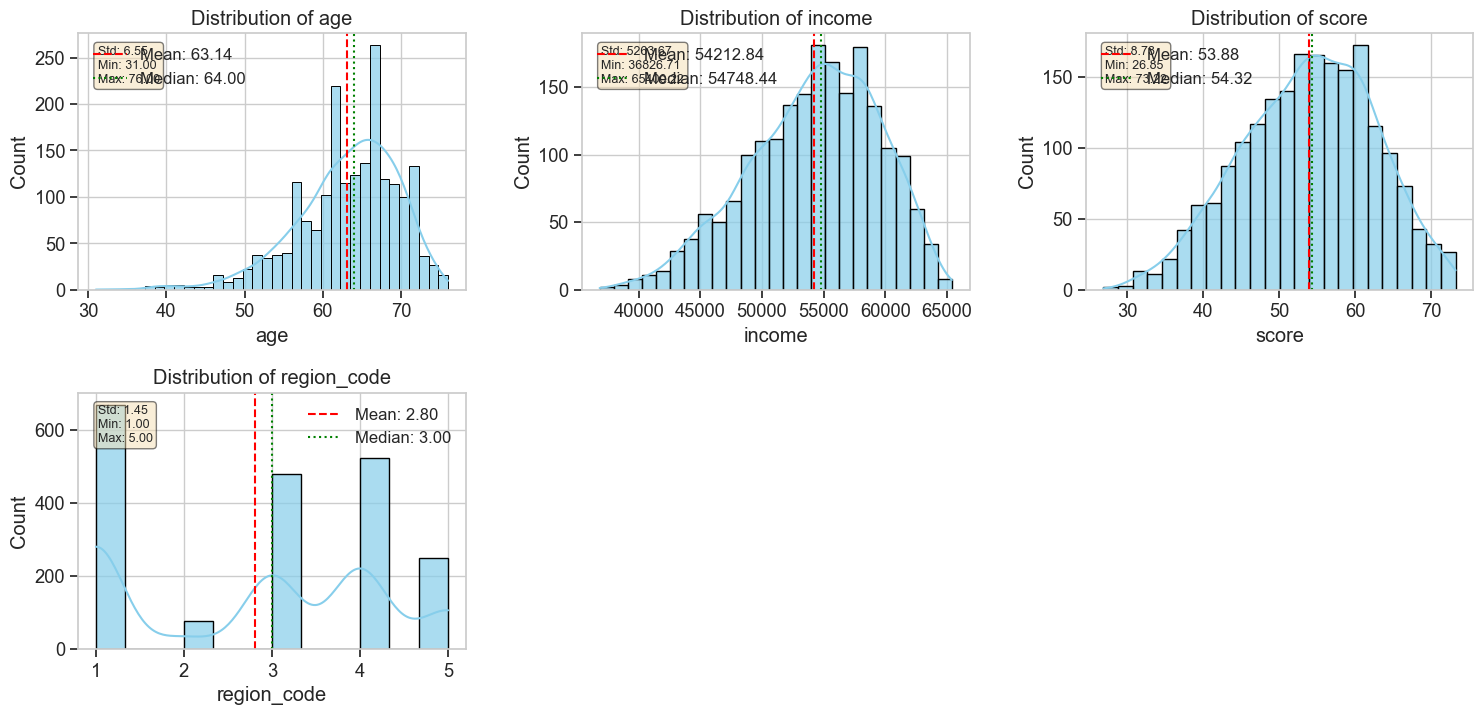

## Correlation Matrix

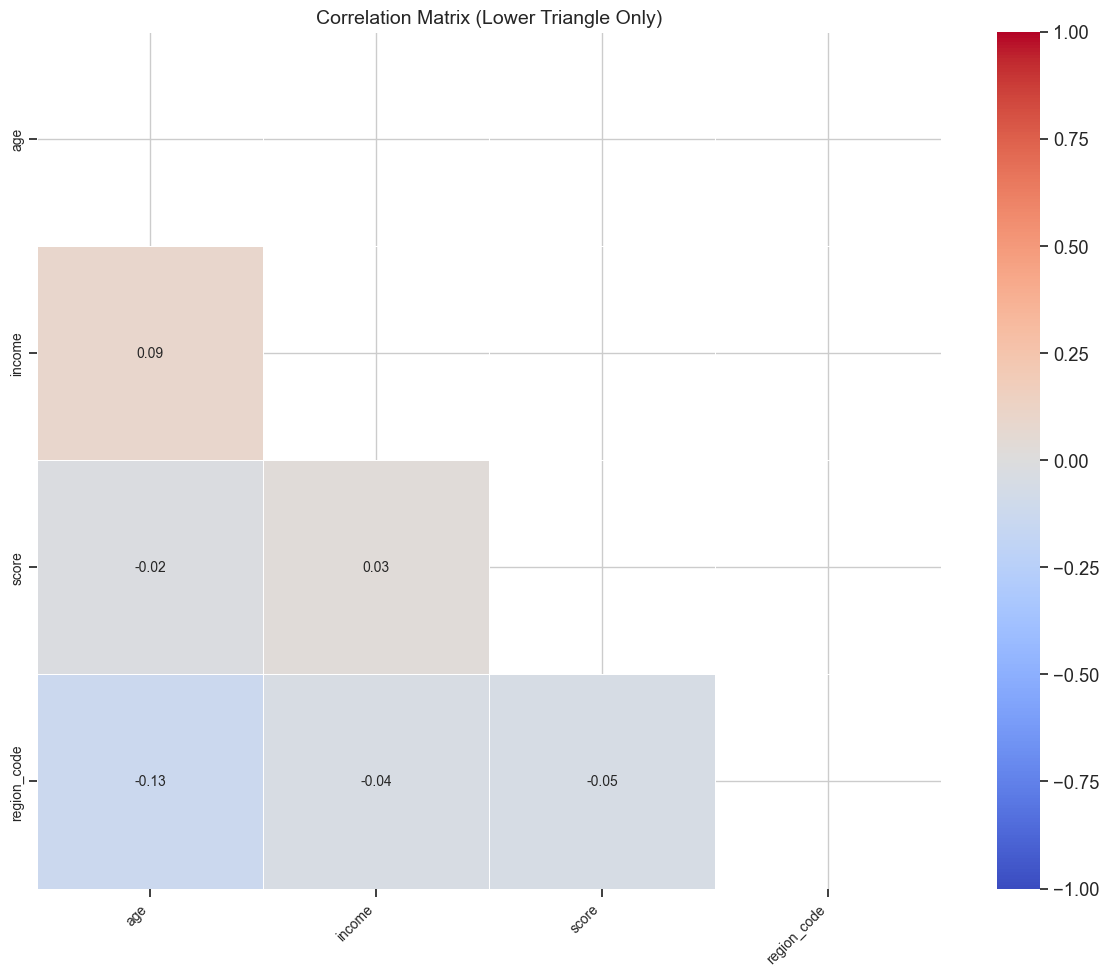

## Categorical Features

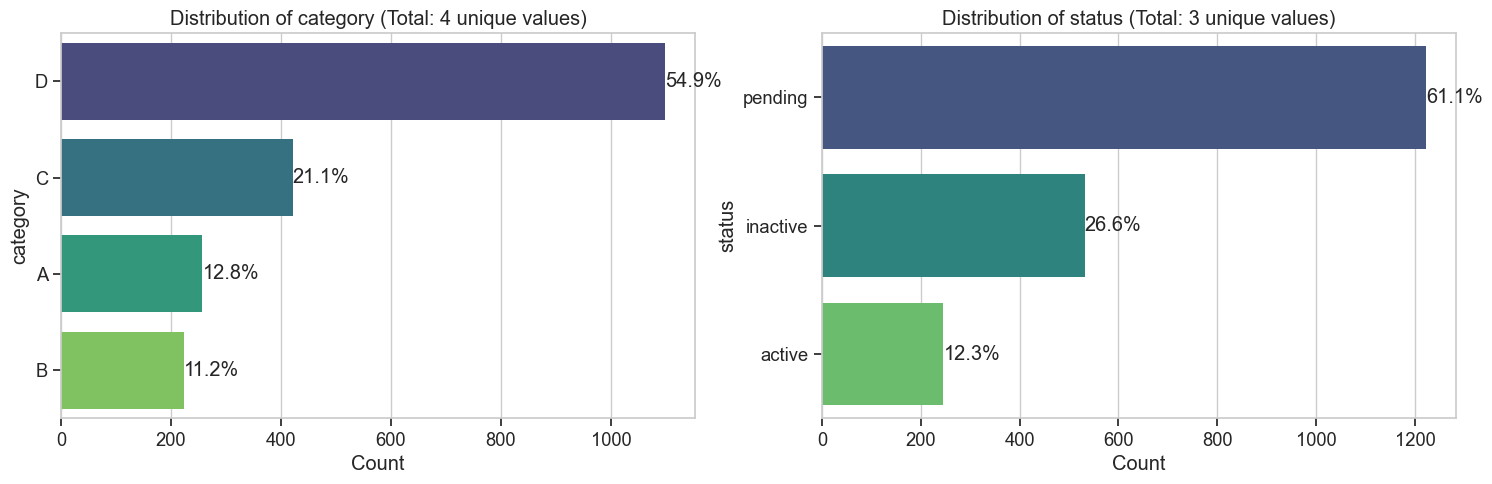

## Categorical-Numerical Relationships

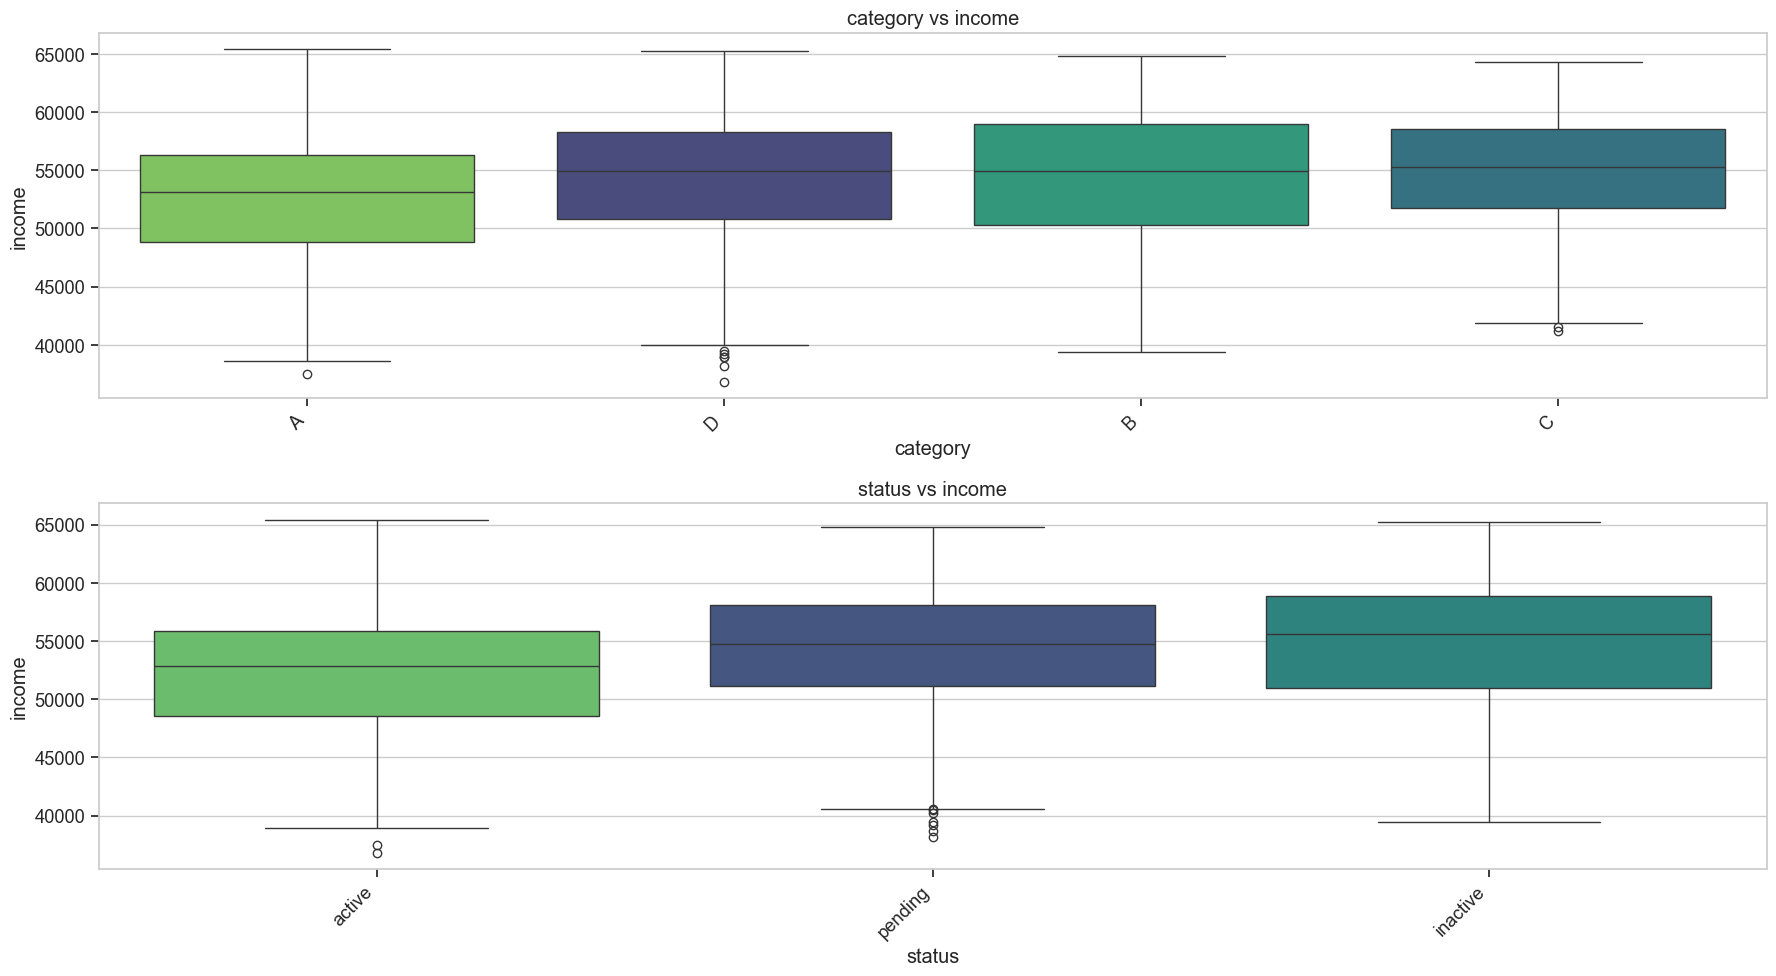

In [5]:
# Exploratory Data Analysis
explore_data(df_gen)



In [ ]:
# Exploratory Data Analysis
explore_data(df_synthetic)



[Back to top](#Index:)

<a id='end'></a>

## End